# Patent Semantics
__Minsu Kim and Dave Friesen - ADS-502-02-SP22__

In [203]:
__author__ = 'Minsu Kim, Dave Friesen'
__email__ = 'misukim@sandiego.edu, dfriesen@sandiego.edu'
__version__ = '1.0'
__date__ = 'April 2022'
__license__ = 'MIT'

### Problem Statement: *Patent application reviews require significant manual reconciliation of synonymic phrases, to support efficient approvals of distinct inventions.*  

### Hypothesis: *Phrase pairs may be classified in terms of semantic similarity in subject context, and under a 'reasonable' margin of error threshhold. (with a null hypothesis of no classification).*

# Setup

In [204]:
# Import Python libraries
import pandas as pd
import numpy as np

from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer

import matplotlib.pyplot as plt
import seaborn as sns

In [205]:
# Set Pandas options for consistent output
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Set working directory (depending on coder)
%cd '/Users/davidfriesen/Desktop/OneDrive/projects/patent-semantics/data'

/Users/davidfriesen/Library/CloudStorage/OneDrive-Personal/projects/patent-semantics/data


In [206]:
# Set Matplotlib options for consistent visualization look 'n' feel
plt.style.use('default')

plt.rcParams['lines.linewidth'] = '1.5'

plt.rcParams['axes.edgecolor'] = '#999999'
plt.rcParams['axes.titlelocation'] = 'left'
plt.rcParams['axes.titlesize'] = '12'
plt.rcParams['axes.labelsize'] = '9'
plt.rcParams['axes.labelcolor'] = '#999999'
plt.rcParams['axes.spines.top'] = 'False'  # Seaborn automatically despines for relplot()
plt.rcParams['axes.spines.right'] = 'False'  # Seaborn automatically despines for relplot()
plt.rcParams['axes.prop_cycle'] = plt.cycler(color = ['#0070c0']) 
PLT_ALTERNATE_COLOR = 'orange'

plt.rcParams['xtick.color'] = '#cccccc'
plt.rcParams['xtick.labelcolor'] = '#777777'
plt.rcParams['xtick.labelsize'] = '9'
plt.rcParams['ytick.color'] = '#cccccc'
plt.rcParams['ytick.labelcolor'] = '#777777'
plt.rcParams['ytick.labelsize'] = '9'

plt.rcParams['figure.figsize'] = [7, 7 / (16 / 9)]
plt.rcParams['figure.subplot.left'] = 0.17
plt.rcParams['figure.subplot.right'] = 1
plt.rcParams['figure.subplot.bottom'] = 0.19
plt.rcParams['figure.subplot.top'] = 0.82
plt.rcParams['figure.subplot.wspace'] = 0.05
plt.rcParams['figure.subplot.hspace'] = 0.05

# Data Acquisition and Validation

In [207]:
# Instantiate base training and test dataframes
train_df = pd.read_csv('train.csv')
titles_df = pd.read_csv('titles.csv')
test_df = pd.read_csv('test.csv')
sample_submission_df = pd.read_csv('sample_submission.csv')

In [208]:
# Perform basic data validation steps by reviewing dataframe subset and metrics
print('\ntrain_df:\n', train_df.head(5), '\n', train_df.shape, sep = '')
print('\ntitles_df:\n', titles_df.head(5), '\n', titles_df.shape, sep = '')
print('\ntest_df:\n', test_df.head(5), '\n', test_df.shape, sep = '')
print('\nsample_submission_df:\n', sample_submission_df.head(5), '\n', sample_submission_df.shape, sep = '')


train_df:
                 id     anchor                  target context  score
0  37d61fd2272659b1  abatement  abatement of pollution     A47  0.500
1  7b9652b17b68b7a4  abatement          act of abating     A47  0.750
2  36d72442aefd8232  abatement         active catalyst     A47  0.250
3  5296b0c19e1ce60e  abatement     eliminating process     A47  0.500
4  54c1e3b9184cb5b6  abatement           forest region     A47  0.000
(36473, 5)

titles_df:
       code                                              title section  class  \
0         A                                  HUMAN NECESSITIES       A    NaN   
1       A01  AGRICULTURE; FORESTRY; ANIMAL HUSBANDRY; HUNTI...       A  1.000   
2      A01B  SOIL WORKING IN AGRICULTURE OR FORESTRY; PARTS...       A  1.000   
3  A01B1/00  Hand tools (edge trimmers for lawns A01G3/06  ...       A  1.000   
4  A01B1/02  Spades; Shovels {(hand-operated dredgers E02F3...       A  1.000   

  subclass  group  main_group  
0      NaN    NaN         N

__These summary dataframe views show relatively simple structures as identifed by the data provider, including:__

id - unique identifier for phrase set  
anchor - first phrase  
target - second phrase  
context - CPC classification, which indicates subject within which the similarity is to be scored  
score - given similarity, sourced from a combination of one or more manual expert ratings  

__Interesting to note that small size of the *provided* test dataset, which later analysis confirms to be simply a [single] representation of all contexts.__

# Univariate Analysis and Data Preparation

## Data Characteristic Review

In [209]:
# Understand sample characteristics (prospective model features and outcome(s)), including data types
#   (numerical - discrete, continuous; categorical - ordinal, nominal)
print('\ntrain_df data types:\n', train_df.dtypes, sep = '')
print('\ntest_df data types:\n', test_df.dtypes, sep = '')
print('\nsample_submission_df data types:\n', sample_submission_df.dtypes, sep = '')


train_df data types:
id          object
anchor      object
target      object
context     object
score      float64
dtype: object

test_df data types:
id         object
anchor     object
target     object
context    object
dtype: object

sample_submission_df data types:
id       object
score     int64
dtype: object


## Variable Type Transformations

__Given data definitions (see Data Acquisition and Validation above) and types, we determined that variable type transformations are not required for this simple dataset and problem statement.__

## Aggregate, Descriptive Statistic, and Distribution Review

In [210]:
# Categorize word pairs by 'Cooperative Patent Classification' (CPC), per provided context code
context_class = {'A': 'Human Necessities',
                 'B': 'Operations and Transport',
                 'C': 'Chemistry and Metallurgy',
                 'D': 'Textiles',
                 'E': 'Fixed Constructions',
                 'F': 'Mechanical Engineering',
                 'G': 'Physics',
                 'H': 'Electricity',
                 'Y': 'Emerging Cross-Sectional Technologies'}
train_df['context_class'] = train_df['context'].apply(lambda x: context_class.get(x[:1]))

In [211]:
# Generate target word counts for analysis
def word_count(s):
    l = len(str(s).split())
    return l

train_df['target_wc'] = train_df[['target']].apply(lambda s: word_count(*s), axis = 1)

In [212]:
# Categorize given scores (for analysis)
score_levels = [-1, 0, 0.25, 0.5, .75, 1]
score_labels = ['Unrelated', 'Somewhat Related', 'Synonym', 'Close Synonym', 'Close Match']
train_df['score_match'] = pd.cut(
    train_df['score'],
    bins = score_levels,
    labels = score_labels
)

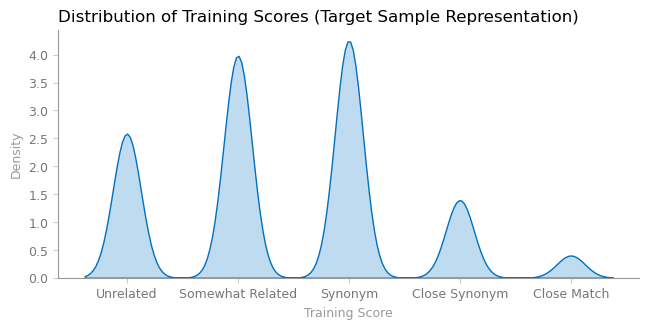

In [213]:
# Visualize/review distribution of provided lables - FOR UNDERSTANDING OF SAMPLE REPRESENTATION,
#   VS. EXPECTED REQUIREMENT FOR MODEL APPROACH
fig, ax = plt.subplots()
sns.kdeplot(
    data = train_df['score'],
    fill = True
).set(
    title = 'Distribution of Training Scores (Target Sample Representation)',
    xlabel = 'Training Score',
)
plt.xticks(score_levels[1:], score_labels)
plt.show()
fig.savefig('training-distribution.svg')

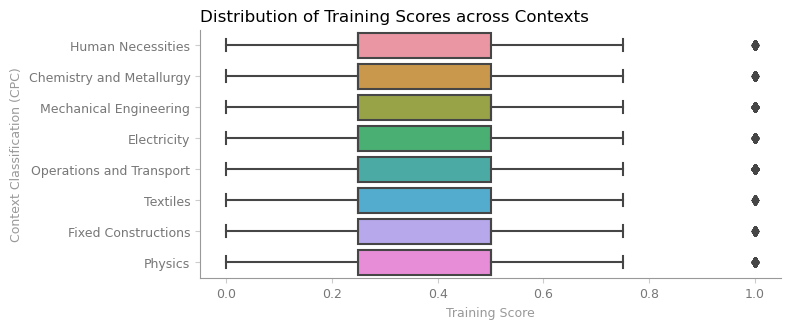

In [214]:
# One other way to look at this is a boxplot view across contexts
fig, ax = plt.subplots()
sns.boxplot(
    x = 'score', y = 'context_class',
    data = train_df,
    orient = 'h'
).set(
    title = 'Distribution of Training Scores across Contexts',
    xlabel = 'Training Score',
    ylabel = 'Context Classification (CPC)'
)
plt.show()
fig.savefig('context-distribution.svg')

__Note that we don't review summary statistics in further detail here given the nature of our semantic classification problem statement and hypothesis. i.e., as noted in code comments, we're more interested in sample representation (stratification) than data distribution per model algorithm requirements.__

## Missing Value Review and Treatment

In [215]:
# Analyze null values - show, along with beginning row count of training data set
rows = train_df.shape[0]
    
print('\nTotal Rows == ', rows, sep = '')
print('\ntrain_df nulls:\n', train_df.isna().sum(), '\n', sep = '')
print('\netest_df nulls:\n', test_df.isna().sum(), sep = '')


Total Rows == 36473

train_df nulls:
id               0
anchor           0
target           0
context          0
score            0
context_class    0
target_wc        0
score_match      0
dtype: int64


etest_df nulls:
id         0
anchor     0
target     0
context    0
dtype: int64


In [216]:
# Analyze missing values - show, along with beginning row count
print('\ntrain_df missing\n\n\n', train_df.info(show_counts = True), sep = '')
print('\ntest_df missing\n\n\n', test_df.info(show_counts = True), sep = '')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36473 entries, 0 to 36472
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   id             36473 non-null  object  
 1   anchor         36473 non-null  object  
 2   target         36473 non-null  object  
 3   context        36473 non-null  object  
 4   score          36473 non-null  float64 
 5   context_class  36473 non-null  object  
 6   target_wc      36473 non-null  int64   
 7   score_match    36473 non-null  category
dtypes: category(1), float64(1), int64(1), object(5)
memory usage: 2.0+ MB

train_df missing


None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36 entries, 0 to 35
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       36 non-null     object
 1   anchor   36 non-null     object
 2   target   36 non-null     object
 3   context  36 non-null     object
dtypes: object(4)


## Outlier Review and Treatment

__With the key assumption that our training dataset is valid per the data provider, outlier treatment is n/a in the context of our problem statement, hypothesis, and model approach.__

## Duplicate Value Review and Treatment

In [217]:
# Do we have any duplicates in our core training and test datasets?
print('\ntrain_df duplicates\n\n', train_df[train_df.duplicated()], sep = '')
print('\ntest_df duplicates\n\n', test_df[test_df.duplicated()], sep = '')


train_df duplicates

Empty DataFrame
Columns: [id, anchor, target, context, score, context_class, target_wc, score_match]
Index: []

test_df duplicates

Empty DataFrame
Columns: [id, anchor, target, context]
Index: []


## Categorical Feature Standardization

__We do not have categorical features to factor/"standardize"__

## Data Normalization/Standardization/Rescaling

__We do not have have variables (prospective features) to normalize/standardize.__

## Data Augmentation (Other)

In [218]:
# Join extended training data with context detail, for further analysis
train_df = pd.merge(
    train_df,
    titles_df[['code', 'title']].set_index('code'), how = 'left', left_on = 'context', right_index = True
)
train_df.rename(columns = {'title': 'context_title'}, inplace = True)

# Multivariate Analysis, Model and Feature Selection/Refinement

__NOTE: We are retaining this section for consideration and coverage; however, "page is intentionally blank" given our problem statememt, hypothesis, and model approach.__

### Key Q n

### Category Variable "Dummy" Encoding

### Model Feature Selection

### Model Feature Preparation

### Model Collinearity Check

# Model Train, Test, and Evaluation

## Experiment 1 - Logistic Regression

__Key Question: Can we classify ~semantic match simply by training a logistic regression model using text embeddings?__

In [219]:
# Create independent predictors and dependent response (target, label)
X = train_df['anchor'] + train_df['target']
y = train_df['score_match']

# Create a TF-IDF (term frequency-inverse document frequency) transformer, with word/phrase relevance
#   based on sklearn's "standard" corpus
transformer = TfidfVectorizer(
    stop_words = 'english',
    lowercase = True,
    max_features = 150000
)

# Create training and test datasets, all from training dataset since it's essentially our full
#   working dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 0)

# Apply TF-IDF transformation to [string-concatenated] phrase combination (predictor)
X_train = transformer.fit_transform(X_train)
X_test = transformer.transform(X_test)

In [220]:
# Create model
model = LogisticRegression(
    solver = 'lbfgs',
    max_iter = 1000,
    multi_class = 'multinomial',
    random_state = 17
)

#
#skf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 17)
#cv = cross_val_score(model, X_train, y_train, cv = skf, scoring = 'f1_micro')
#print(cv, cv.mean())

# Fit model to training data
model = model.fit(X_train, y_train)

# Run model predictions (validation)
y_pred = model.predict(X_test)

                  precision    recall  f1-score   support

     Close Match       0.62      0.01      0.03       361
   Close Synonym       0.44      0.11      0.17      1230
Somewhat Related       0.51      0.54      0.52      3556
         Synonym       0.45      0.67      0.54      3663
       Unrelated       0.51      0.34      0.41      2132

        accuracy                           0.48     10942
       macro avg       0.51      0.33      0.33     10942
    weighted avg       0.49      0.48      0.45     10942

[[   5   24   73  226   33]
 [   1  131  303  690  105]
 [   1   38 1918 1325  274]
 [   1   63  850 2453  296]
 [   0   40  625  742  725]]
[[[10578     3]
  [  356     5]]

 [[ 9547   165]
  [ 1099   131]]

 [[ 5535  1851]
  [ 1638  1918]]

 [[ 4296  2983]
  [ 1210  2453]]

 [[ 8102   708]
  [ 1407   725]]]


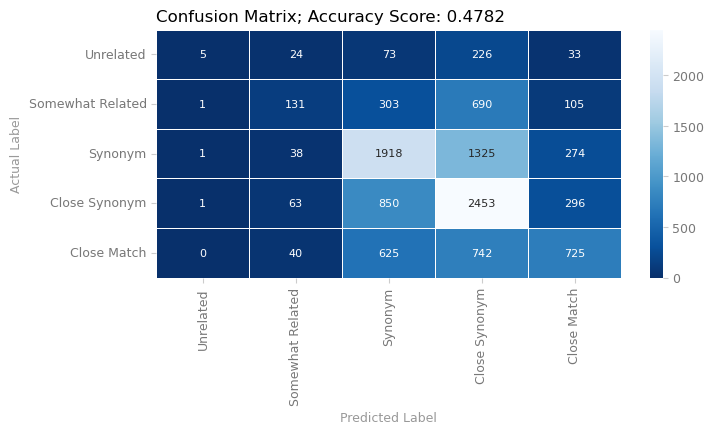

In [221]:
# Generate classification report, confusion matrix, and multilabel confusion matrix (effectively
#   2x2 for all classes) and summarize model results
cr = classification_report(y_test, y_pred)
cm = metrics.confusion_matrix(y_test, y_pred)
mcm = metrics.multilabel_confusion_matrix(y_test, y_pred)
score = model.score(X_test, y_test)

# Output each
print(cr)
print(cm)
print(mcm)

# Visualize confusion matrix
fig, ax = plt.subplots()
sns.heatmap(
    data = cm,
    cmap = 'Blues_r',
    annot = True,
    fmt = ".0f", linewidths = .5,
    annot_kws = {"fontsize":8}
).set(
    title = 'Confusion Matrix; Accuracy Score: {0:.4f}'.format(score),
    xlabel = 'Predicted Label',
    ylabel = 'Actual Label'
)
labels = pd.DataFrame(pd.DataFrame(y_train).groupby('score_match'))
labels = labels[labels.columns[0]].values.tolist()
ax.set_xticklabels(labels, rotation = 90)
ax.set_yticklabels(labels, rotation = 0)
plt.show()
fig.savefig('confusion-matrix.svg')

# Do standard calcs (for practice)
FP = cm.sum(axis = 0) - np.diag(cm)  
FN = cm.sum(axis = 1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP / (TP + FN)
# Specificity or true negative rate
TNR = TN / (TN + FP) 
# Precision or positive predictive value
PPV = TP / (TP + FP)
# Negative predictive value
NPV = TN / (TN + FN)
# Fall out or false positive rate
FPR = FP / (FP + TN)
# False negative rate
FNR = FN / (TP + FN)
# False discovery rate
FDR = FP / (TP + FP)

# Overall accuracy
ACC = (TP + TN) / (TP + FP + FN + TN)

__[Need logistic regression evaluation comments here]__

## Experiment 2 - BERT
__(Bidirectional Encoder Representation from Transformers)__

__Key Question: To what extent can we leverage open source Artificial Neural Networks (and supporting corpora) to classify phrase pairs in terms of semantic similarity?__

In [222]:
# Generate text embeddings and resulting similarity scores for full training set
#   Note we are using SBERT (SentenceBERT), a Python neural-network based. We are starting with a
#   model pre-trained across a wide corpus, leveraging this vs. narrowly building and training here.
model_name = 'bert-base-nli-mean-tokens'
model = SentenceTransformer(model_name)

# Function for determining/applying phrase pair similarity
def sim_score(a, b):
    sentence_vecs = model.encode([a, b])
    sim = cosine_similarity([sentence_vecs[0]], sentence_vecs[1:])[0, 0]
    print(a, b, sim)
    return sim

# The following was completed (long execution time) and written (below) to an extended training data set
#train_df['sim'] = train_df[['anchor', 'target']].apply(lambda t: sim_score(*t), axis = 1)
#train_df.to_csv('train_ext.csv', index = False)

# Subsequently, just read in this extended training data with similarty score and merge join with core set
train_ext_df = pd.read_csv('train_ext.csv')
train_df = pd.merge(
    train_df,
    train_ext_df[['id', 'sim']].set_index('id'), how = 'left', left_on = 'id', right_index = True
)

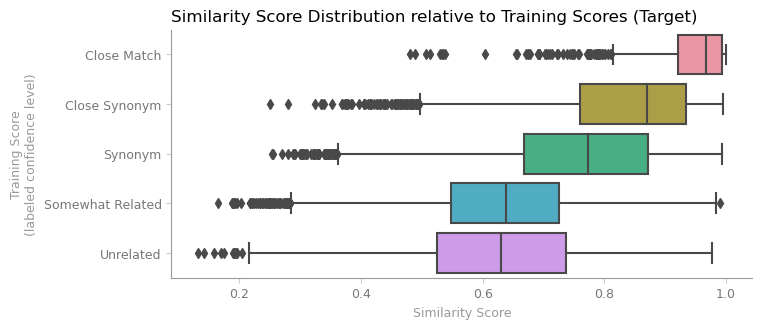

In [223]:
# Visualize/review distribution of our SentenceTransform/cosine similarity scores vs. given training scores
fig, ax = plt.subplots()
sns.boxplot(
    x = 'sim', y = 'score_match',
    data = train_df,
    order = ['Close Match', 'Close Synonym', 'Synonym', 'Somewhat Related', 'Unrelated']
).set(
    title = 'Similarity Score Distribution relative to Training Scores (Target)',
    xlabel = 'Similarity Score',
    ylabel = 'Training Score\n(labeled confidence level)'
)
plt.show()
fig.savefig('similarity-v-training.png')

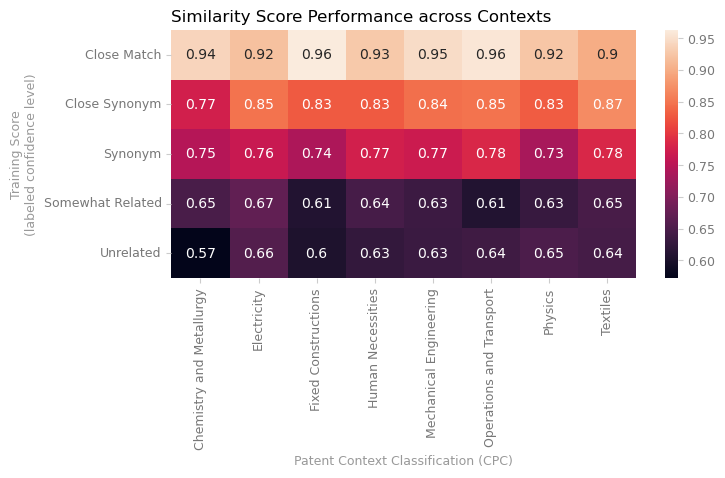

In [224]:
# Subset and pivot table for heat map visualization
hm = train_df.pivot_table(
    values = 'sim',
    index = 'score_match',
    columns = 'context_class',
    aggfunc = np.mean,
    sort = False)

# Visualize similarity score vs. given score by context
fig, ax = plt.subplots()
sns.heatmap(
    data = hm, annot = True
).set(
    title = 'Similarity Score Performance across Contexts',
    xlabel = 'Patent Context Classification (CPC)',
    ylabel = 'Training Score\n(labeled confidence level)'
)
ax.invert_yaxis()
plt.show()
fig.savefig('similarity-v-training-by-context.svg')

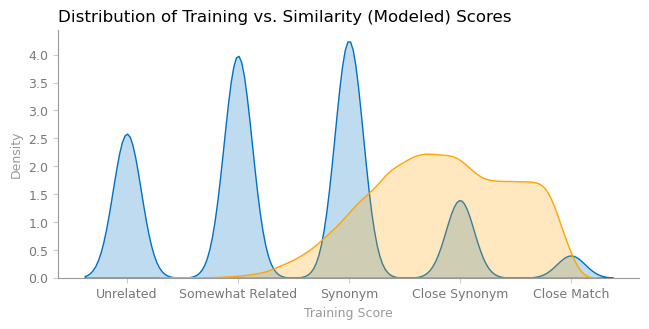

In [225]:
# 'Normalize' similarity scores in quartiles for ~distribution comparison to given scores
def q(val, q25, q50, q75, q100):
    return (((q25 < val <= q50) * 0.25) + 
            ((q50 < val <= q75) * 0.5) + 
            ((q75 < val <= q100) * 0.75) +
            ((q100 < val) * 1.0))

a = np.quantile(train_df['sim'], 0.25)
b = np.quantile(train_df['sim'], 0.50)
c = np.quantile(train_df['sim'], 0.75)
d = np.quantile(train_df['sim'], 1.0)
train_df['sim_norm'] = train_df['sim'].apply((lambda x: q(x, a, b, c, d)))

# Visualize/review distribution of provided lables
fig, ax = plt.subplots()
sns.kdeplot(
    data = train_df['score'],
    fill = True
).set(
    title = 'Distribution of Training vs. Similarity (Modeled) Scores',
    xlabel = 'Training Score',
)

sns.kdeplot(
    data = train_df['sim'],
    fill = True,
    color = PLT_ALTERNATE_COLOR
)

plt.xticks(score_levels[1:], score_labels)
plt.show()
fig.savefig('training-vs-similarity-distribution.svg')

In [226]:
# There is some statistical analysis to do here, including understanding the scale of cosine similarity vs.
#   the given scale, which is more probability-based.
# We may have a case to make about lack of context within semantic similarity, which either needs to
#   be overcome in the model itself or in the context within which the model is used?
# An alternative is we could train based on a contextual corpus. . .
# etc.

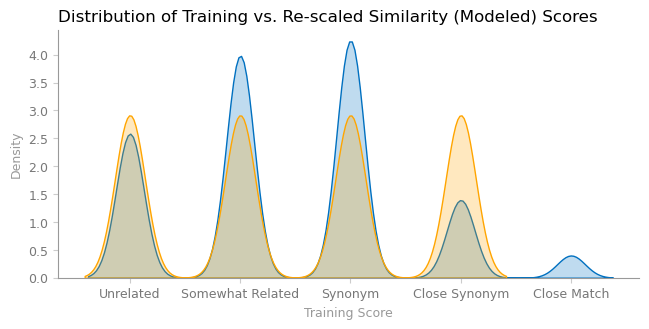

In [231]:
# Re-scale similarity scores in quartiles for ~distribution comparison to given scores
def q(val, q25, q50, q75, q100):
    return (((q25 < val <= q50) * 0.25) + 
            ((q50 < val <= q75) * 0.5) + 
            ((q75 < val <= q100) * 0.75) +
            ((q100 < val) * 1.0))

a = np.quantile(train_df['sim'], 0.25)
b = np.quantile(train_df['sim'], 0.50)
c = np.quantile(train_df['sim'], 0.75)
d = np.quantile(train_df['sim'], 1.0)
train_df['sim_norm'] = train_df['sim'].apply((lambda x: q(x, a, b, c, d)))

# Visualize/review distribution of provided lables
fig, ax = plt.subplots()
sns.kdeplot(
    data = train_df['score'],
    fill = True
).set(
    title = 'Distribution of Training vs. Re-scaled Similarity (Modeled) Scores',
    xlabel = 'Training Score',
)

sns.kdeplot(
    data = train_df['sim_norm'],
    fill = True,
    color = PLT_ALTERNATE_COLOR
)

plt.xticks(score_levels[1:], score_labels)
plt.show()
fig.savefig('training-vs-norm-similarity-distribution.svg')